In [1]:
print("Multimedia Security Experiment 12")

Multimedia Security Experiment 12


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import myipf # 前面的实验编写的函数
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline
plt.rcParams["font.sans-serif"] = ["SimHei"] # 用来正常显示中文
plt.rcParams["axes.unicode_minus"] = False # 用来正常显示负号
%config InlineBackend.figure_format = "svg"

## 二值图像信息隐藏
- 利用两种不同的方法实现信息隐藏
- 分析二值图像信息隐藏的不可觉察性、容量以及鲁棒性等性能指标之间的关系
- 利用两幅图像的与运算决定是否嵌入数据或嵌入什么样的数据

In [3]:
img = plt.imread("standard_test_images/lena_gray_256.tif")
bin_img = cv.adaptiveThreshold(img, 1, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 255, 0)

## 分块，游程编码

In [4]:
def insertMark2(src, data):
    length = len(data)-2
    row, col = int(np.floor(src.shape[0]/length)), int(np.floor(src.shape[1]/length))
    total_pixel = row*col
    half_pixel = np.ceil(total_pixel/2)
    dst_image = src.copy()
    for k in range(length):
        tmp_block = dst_image[k*row:k*row+row, k*col:k*col+col].copy()
        white_pixel = np.count_nonzero(tmp_block)
        black_pixel = total_pixel - white_pixel
        if data[k+2] == "1":
            for i in range(tmp_block.shape[0]):
                for j in range(tmp_block.shape[1]):
                    if tmp_block[i][j] == 0 and white_pixel < half_pixel:
                        tmp_block[i][j] = 1
                        white_pixel += 1
        else:
            for i in range(tmp_block.shape[0]):
                for j in range(tmp_block.shape[1]):
                    if tmp_block[i][j] == 1 and black_pixel < half_pixel:
                        tmp_block[i][j] = 0
                        black_pixel += 1
        dst_image[k*row:k*row+row, k*col:k*col+col] = tmp_block
    
    return dst_image

def getMark2(src, length):
    data = "0b"
    row, col = int(np.floor(src.shape[0]/length)), int(np.floor(src.shape[1]/length))
    total_pixel = row*col
    half_pixel = np.ceil(total_pixel/2)
    for k in range(length):
        white_pixel = np.count_nonzero(src[k*row:k*row+row, k*col:k*col+col])
        black_pixel = total_pixel - white_pixel
        if white_pixel >= half_pixel:
            data += "1"
        else:
            data += "0"
    return data

In [5]:
t_img = insertMark2(bin_img, bin(21553324423))

### 结果验证

In [6]:
getMark2(t_img, 35) == bin(21553324423)

True

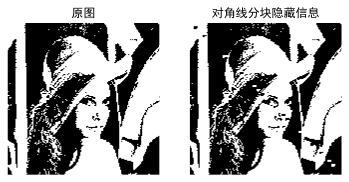

均方差： 0.0055999755859375
峰值信噪比： 70.6489422723952


In [7]:
plt.subplot(1, 2, 1), plt.imshow(bin_img, cmap="gray"), plt.axis("off"), plt.title("原图")
plt.subplot(1, 2, 2), plt.imshow(t_img, cmap="gray"), plt.axis("off"), plt.title("对角线分块隐藏信息")
plt.show()
myipf.calcMSEPSNR(bin_img, t_img)

In [8]:
def insertMark3(src, data):
    vec_image = src.flatten()
    running_len_table = calRunningLength(src)
    length, k, i, pre_sum = vec_image.shape[0]-1, 0, 0, 0
    while k < length:
        if k > 1:
            pre_sum += running_len_table[k-1] + running_len_table[k-2]
        if running_len_table[k] > 1 or running_len_table[k+1] > 1:
            if running_len_table[k] >= running_len_table[k+1]:
                modify_point = pre_sum + running_len_table[k]-1
            else:
                modify_point = pre_sum + running_len_table[k]
            if data[i+2] == "1":
                if running_len_table[k] % 2 == 0:
                    vec_image[modify_point] = (vec_image[modify_point]+1) % 2
            else:
                if running_len_table[k] % 2 == 1:
                    vec_image[modify_point] = (vec_image[modify_point]+1) % 2
            i += 1
        k += 2;
        if i == len(data)-2:
            break

    return vec_image.reshape(src.shape[0], src.shape[1])

def getMark3(src, length):
    vec_image = src.flatten()
    running_len_table = calRunningLength(src)
    k, i = 0, 0
    data = "0b"
    while i < length:
        if running_len_table[k] > 1 or running_len_table[k+1] > 1:
            if running_len_table[k] % 2 == 1:
                data += "1"
            else:
                data += "0"
            i += 1;
        k += 2
    return data
    
def calRunningLength(src):
    vec_image = src.flatten()
    running_len_table, length, k = [], vec_image.shape[0], 0
    while k < length:
        pre_pixel = vec_image[k]
        count = 1
        while k+1 < length and vec_image[k+1] == pre_pixel:
            count += 1
            k     += 1
        running_len_table.append(count)
        k += 1

    return running_len_table

In [9]:
tt_img = insertMark3(bin_img, bin(21553324423))

### 结果验证

In [10]:
getMark2(t_img, 35) == bin(21553324423)

True

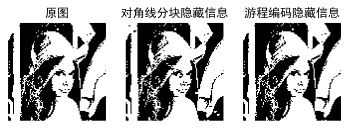

均方差： 0.0003509521484375
峰值信噪比： 82.67832455474016


In [11]:
plt.subplot(1, 3, 1), plt.imshow(bin_img, cmap="gray"), plt.axis("off"), plt.title("原图")
plt.subplot(1, 3, 2), plt.imshow(t_img, cmap="gray"), plt.axis("off"), plt.title("对角线分块隐藏信息")
plt.subplot(1, 3, 3), plt.imshow(tt_img, cmap="gray"), plt.axis("off"), plt.title("游程编码隐藏信息")
plt.show()
myipf.calcMSEPSNR(bin_img, tt_img)

In [19]:
def insertMark4(src, data):
    mask = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])
    row, col, length, k = int(np.floor(src.shape[0]/3)), int(np.floor(src.shape[1]/3)), len(data)-2, 0
    dst_image = src.copy()
    for i in range(row):
        for j in range(col):
            block = dst_image[i*3:i*3+3, j*3:j*3+3] & mask
            if np.sum(block) == 4 and k < length:
                if data[k+2] == "1":
                    dst_image[i*3+1][j*3+1] = 1
                else:
                    dst_image[i*3+1][j*3+1] = 0
                k += 1
    
    return dst_image

def getMark4(src, length):
    mask = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])
    row, col, k = int(np.floor(src.shape[0]/3)-1), int(np.floor(src.shape[1]/3)-1), 0
    data = "0b"
    for i in range(row):
        for j in range(col):
            block = src[i*3:i*3+3, j*3:j*3+3] & mask
            if np.sum(block) == 4 and k < length:
                if src[i*3+1][j*3+1] == 1:
                    data += "1"
                else:
                    data += "0"
                k += 1
    return data

In [20]:
ttt_img = insertMark4(bin_img, bin(21553324423))

In [21]:
getMark4(ttt_img, 35) == bin(21553324423)

True

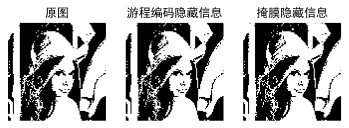

均方差： 0.00030517578125
峰值信噪比： 83.28530295827628


In [22]:
plt.subplot(1, 3, 1), plt.imshow(bin_img, cmap="gray"), plt.axis("off"), plt.title("原图")
plt.subplot(1, 3, 2), plt.imshow(tt_img, cmap="gray"), plt.axis("off"), plt.title("游程编码隐藏信息")
plt.subplot(1, 3, 3), plt.imshow(ttt_img, cmap="gray"), plt.axis("off"), plt.title("掩膜隐藏信息")
plt.show()
myipf.calcMSEPSNR(bin_img, ttt_img)

## 结论
就实验结果而言，使用分块的信息隐藏不可觉察性很低，但随着分块的变小，不可觉察性会增加，但鲁棒性会降低。其他两种不可觉察性都很好，和原二值图的峰值信噪比均为80dB以上。  
鲁棒性就分块的方法强一点，其他两种极其容易产生误码，因为这两种方法都把信息隐藏在单个像素上，一旦有噪声或滤波，隐藏的信息很容易就被破坏。  
最后一种方法还可以延申，比如0和1采用不同的掩膜，或者选择更加不易察觉变化的掩膜，增加掩膜尺寸。我这里采用是3×3十字形的掩膜，中心位置隐藏信息，可以提高不可觉查性。  

表格以最大容量为标准。

分块尺寸|容量(C/F)|质量(PSNR)
-|-|-
分块|0.00005|70.649
游程|0.125|82.678
掩膜3×3|0.014|83.285